In [1]:
# Import the necessary libraries that will be needed to carry out the tasks
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Organize data into train, valid, test dirs
os.chdir('C:\data\dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [3]:
# Setting up paths for data files.

train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [4]:
# We need to put the data in a format that the model understands.
# In keras, we do so with the ImageGenerator() method.
# This will create batches of data from the directory where the datasets resides
# And these batches of data will be passed to the sequential model

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
# Verifying the number of classes and images for our train, valid and test sets
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
# Checking the indices of each label
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [7]:
# Overview of images from a particular batch
imgs, labels = next(train_batches)

In [8]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are place
# Function taken directly from Tensorflow website
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

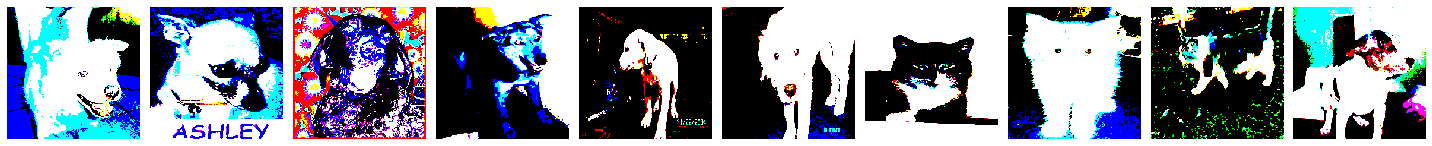

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [9]:
# Plotting images from the 'imgs' batches along their labels
plotImages(imgs)
print(labels)

In [10]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top =False)
model = Sequential([
    mobile,
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [11]:
# Check out a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 32)          294944    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [15]:
model.get_weights()

[array([[[[ 8.87084053e-14,  2.96805650e-01,  6.37018029e-03,
            1.65614850e-13,  1.67507152e-14,  2.32599691e-01,
           -2.11688027e-01, -2.89562464e-01, -4.32953903e-15,
            9.02518332e-02,  3.74022692e-01,  9.35078702e-14,
            1.86451197e-01,  1.25418112e-01,  1.95117351e-02,
            4.56319394e-05, -5.14434686e-13, -1.83411270e-01,
            4.23258543e-01, -2.81243533e-01,  1.27436947e-13,
            8.86099631e-15, -6.10434078e-02,  2.95206159e-01,
            1.57009251e-02,  2.83806771e-03,  3.10450763e-01,
           -1.53950348e-01, -5.49012601e-01,  2.73573875e-01,
           -4.22438890e-01,  4.44939779e-03],
          [ 1.05321493e-13, -3.62159193e-01,  1.64814759e-02,
            1.44252747e-13,  5.91760866e-14,  1.75675690e-01,
           -1.03432484e-01,  1.08966529e-01,  8.52340540e-15,
           -1.76948816e-01,  3.73113334e-01,  1.19941383e-13,
            1.69542685e-01,  1.34118915e-01,  3.04826647e-02,
            4.60369374e-

In [13]:
# Preparing the model for training
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=1)

Train for 100 steps, validate for 20 steps
Epoch 1/5
100/100 [==============================] - 877s 9s/step - loss: 0.4951 - accuracy: 0.8370 - val_loss: 0.2802 - val_accuracy: 0.8650
Epoch 2/5
100/100 [==============================] - 948s 9s/step - loss: 0.1931 - accuracy: 0.9250 - val_loss: 0.1934 - val_accuracy: 0.9400
Epoch 3/5
100/100 [==============================] - 847s 8s/step - loss: 0.1800 - accuracy: 0.9280 - val_loss: 0.4981 - val_accuracy: 0.7850
Epoch 4/5
100/100 [==============================] - 840s 8s/step - loss: 0.1604 - accuracy: 0.9380 - val_loss: 0.6585 - val_accuracy: 0.8500
Epoch 5/5
100/100 [==============================] - 905s 9s/step - loss: 0.1841 - accuracy: 0.9280 - val_loss: 0.6156 - val_accuracy: 0.7150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

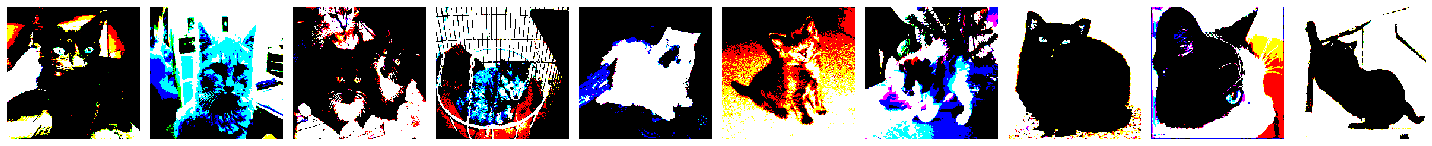

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
# Get a batch of test data from the test images and then plot that batch
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
# View the unshuffled test set
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
# Making a prediction on the test set
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
# Rounding the probabilities to zero and one
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [20]:
# Creating a confusion matrix to view the performance of the model on the test set
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [21]:
# Function to plot a confusion Matrix
# Directly copied from the Scikit Learn website
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
# Checking the indices of each label
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[46  4]
 [14 36]]


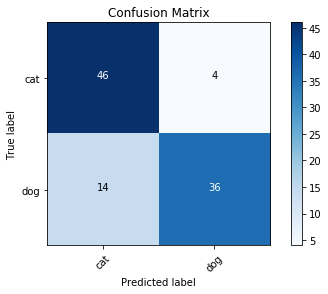

In [23]:
# Defining the labels of the confusion Matrix and plotting it
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# ASSIGNMENT 2

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Downloading MobileNet Model
mobile = tf.keras.applications.mobilenet.MobileNet()

In [26]:
def prepare_image(file):
    img_path = 'C:\data\MobileNet-samples'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

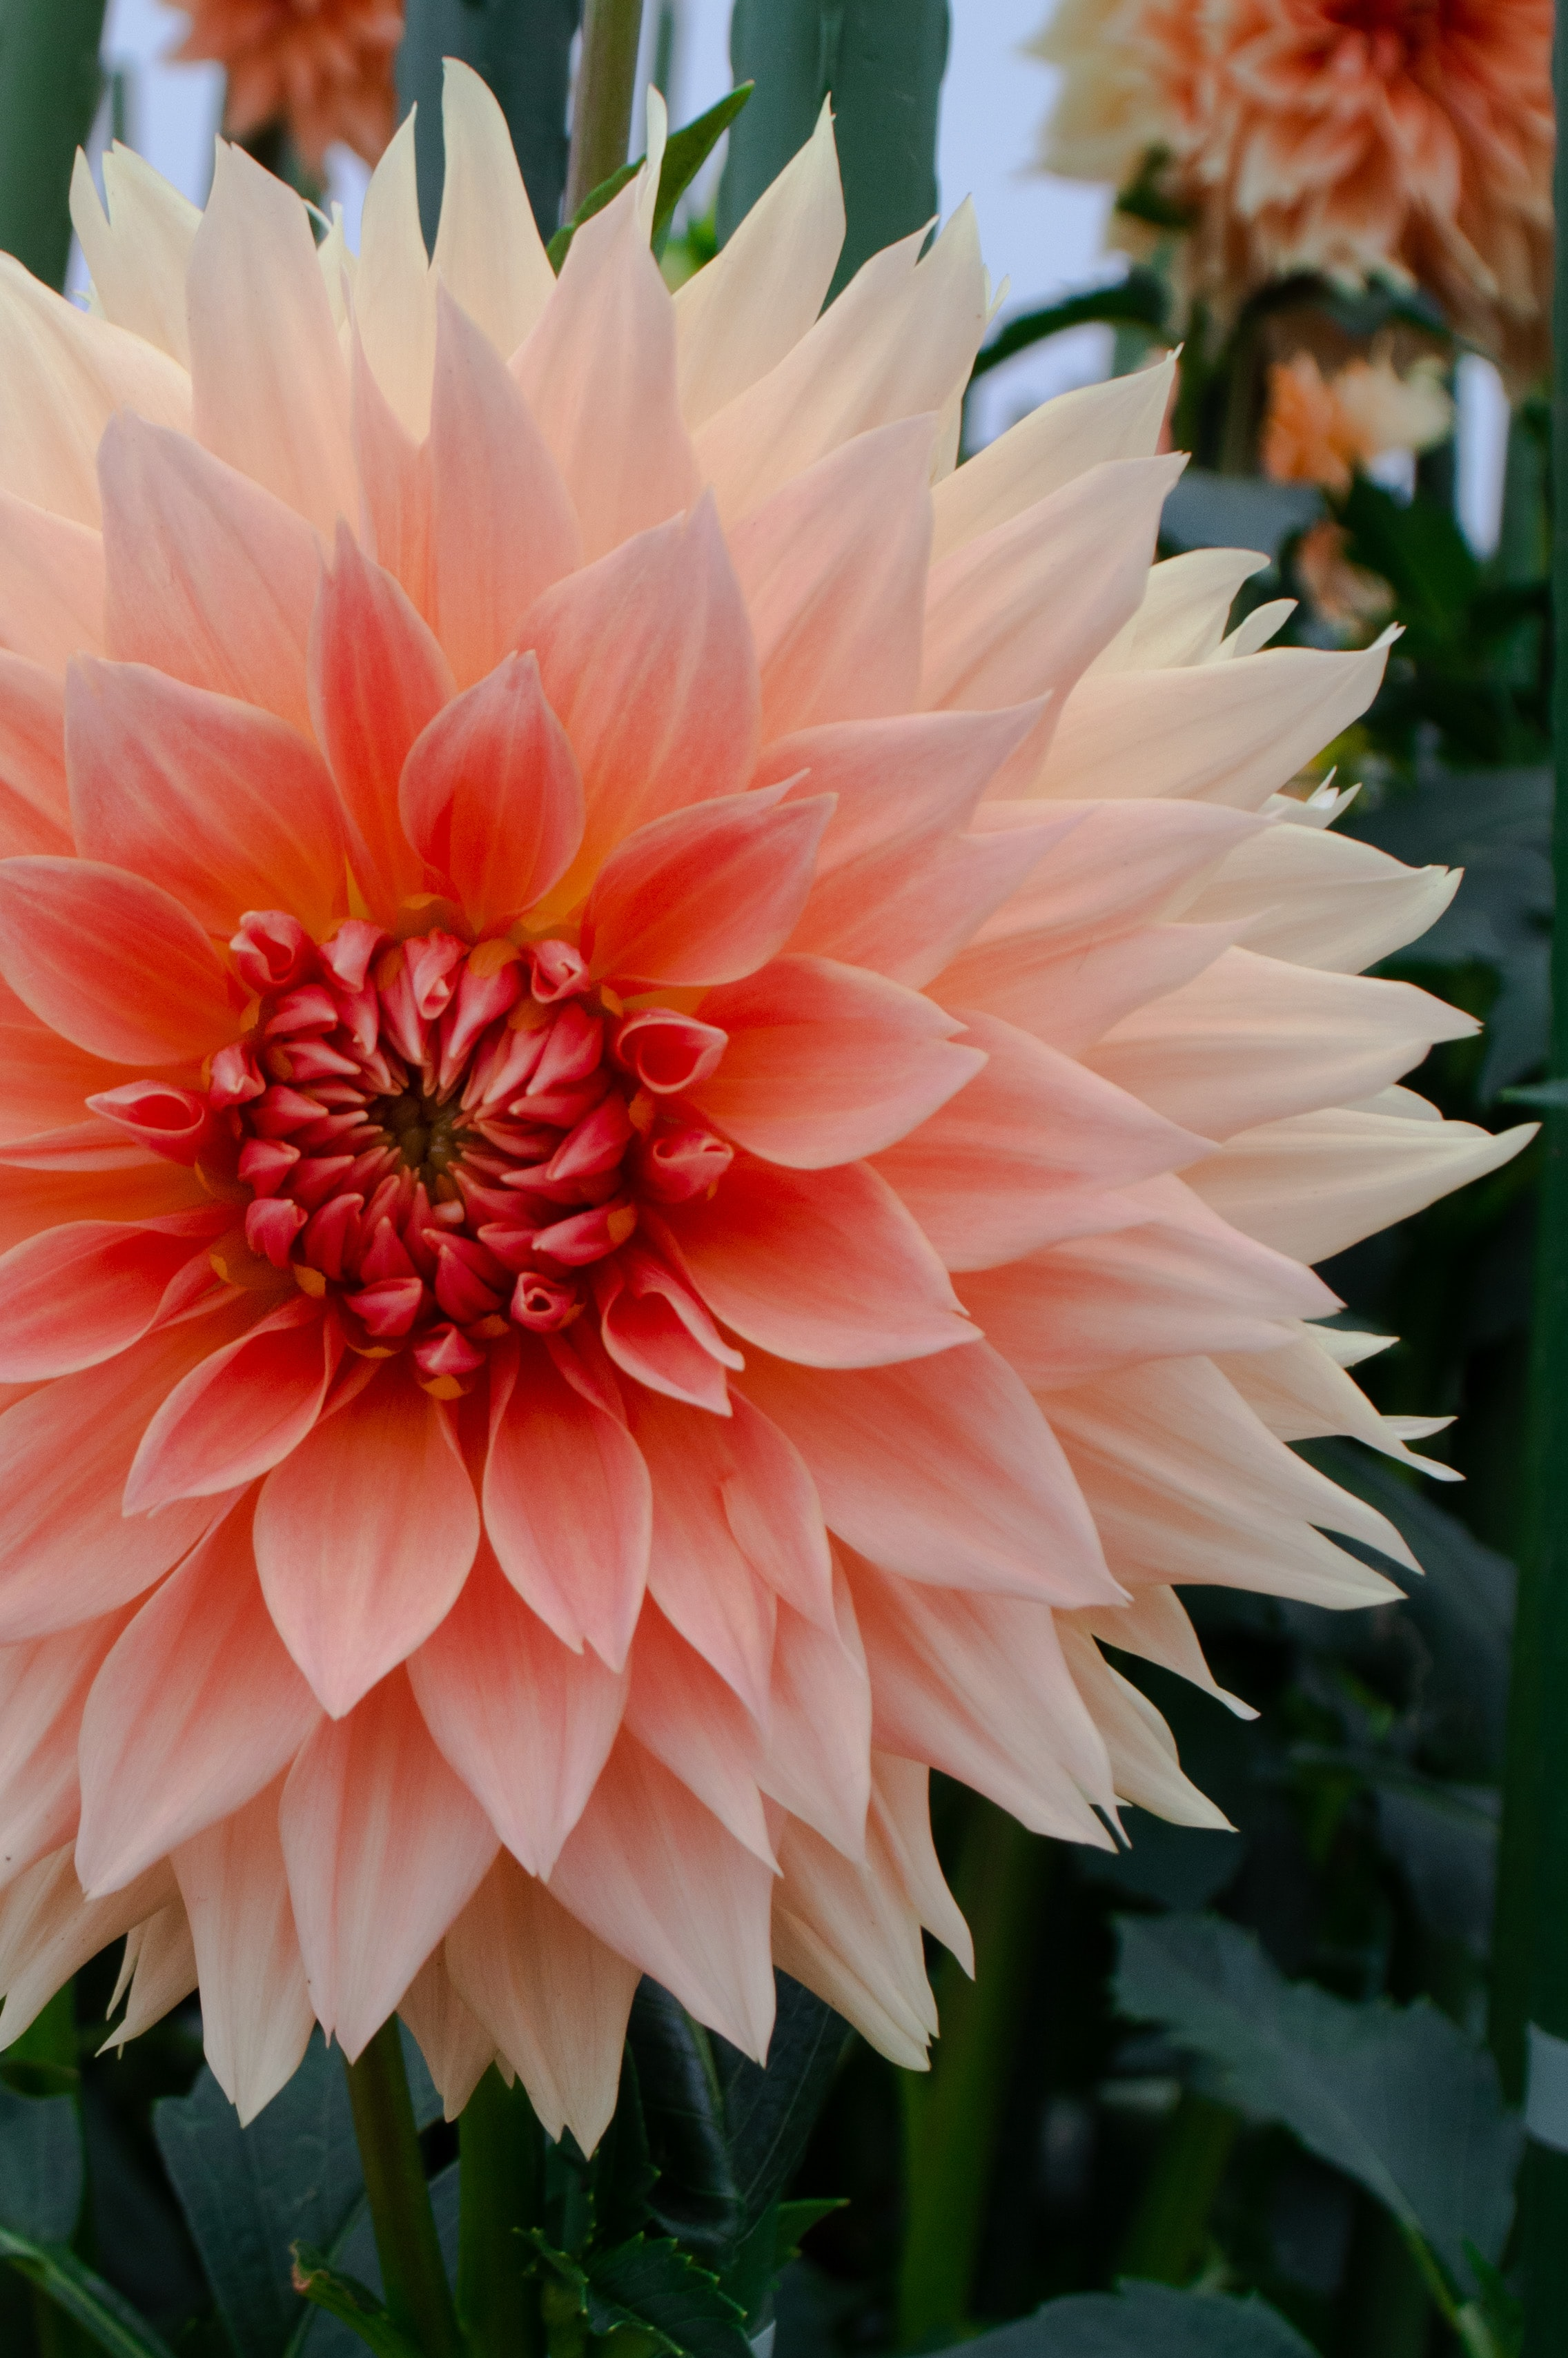

In [27]:
from IPython.display import Image
Image(filename='C:\data\MobileNet-samples/3.jpg', width=300, height=200)

In [28]:
preprocessed_image = prepare_image('/3.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

[[('n11939491', 'daisy', 0.7611284),
  ('n01944390', 'snail', 0.06896624),
  ('n02206856', 'bee', 0.063699454),
  ('n01914609', 'sea_anemone', 0.022086576),
  ('n02219486', 'ant', 0.021986205)]]

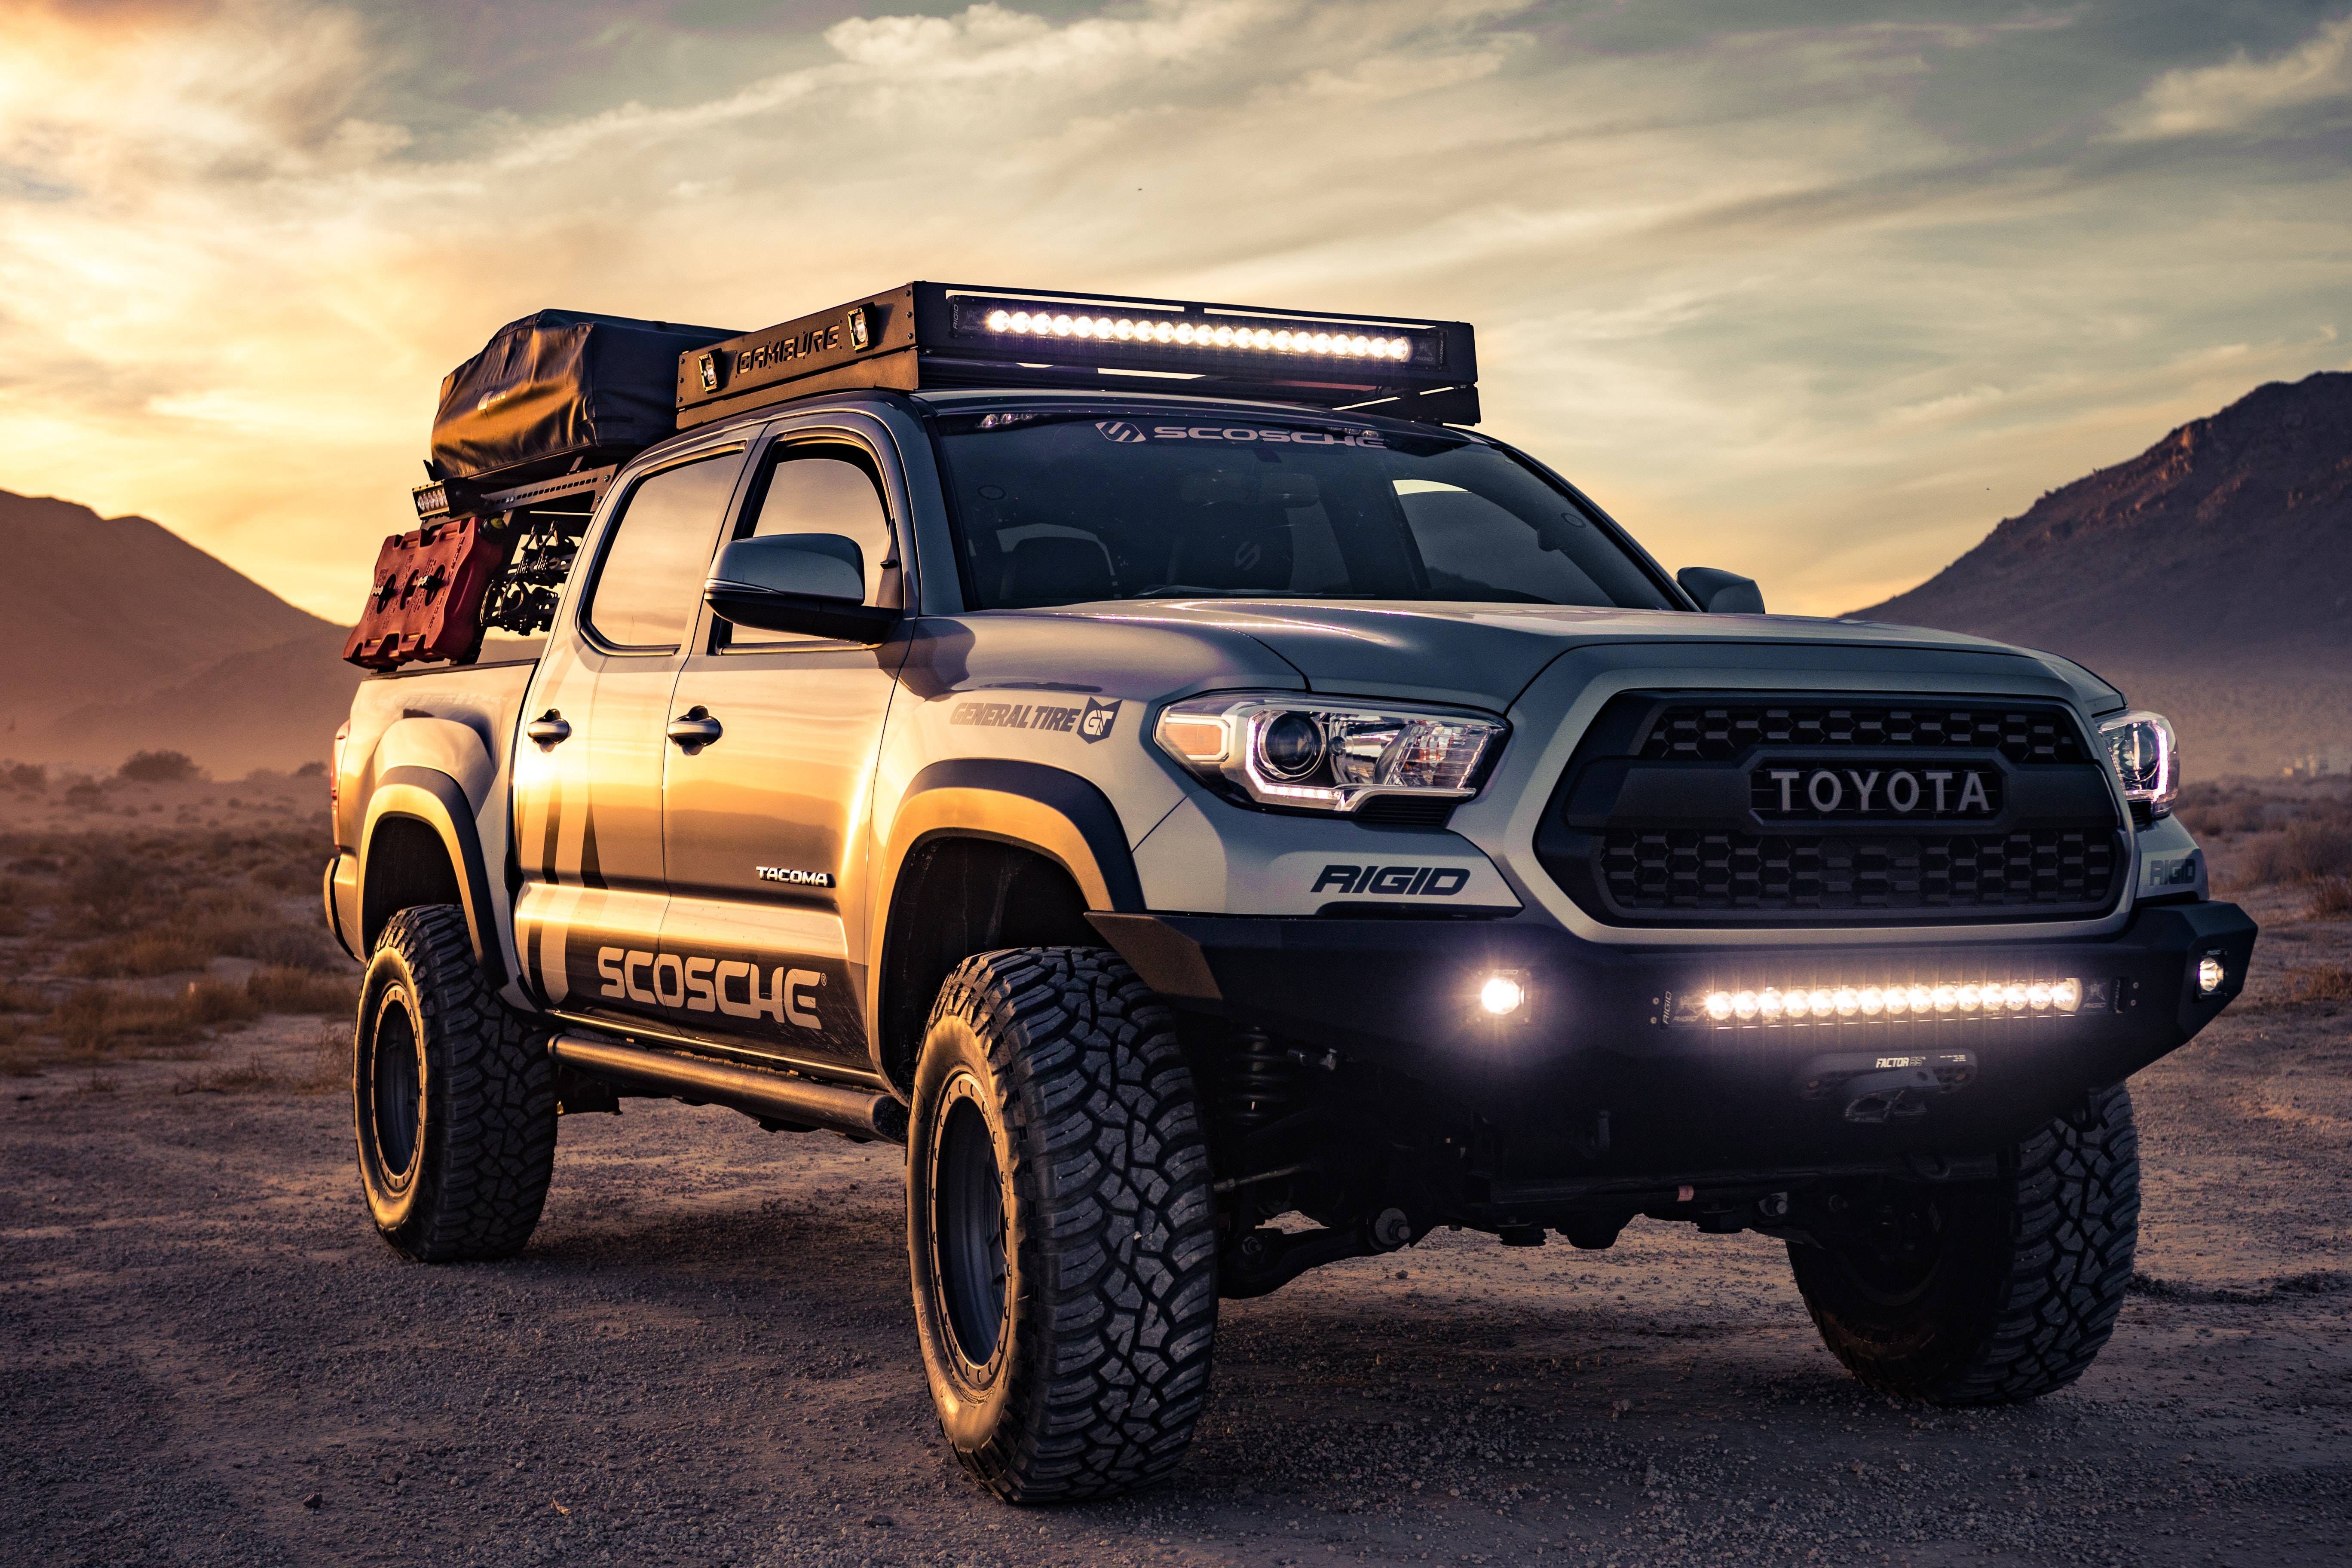

In [29]:
Image(filename='C:\data\MobileNet-samples/4.jpg', width=300, height=200)

In [30]:
preprocessed_image = prepare_image('/4.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

[[('n03594945', 'jeep', 0.7522396),
  ('n04037443', 'racer', 0.059896346),
  ('n02974003', 'car_wheel', 0.031931378),
  ('n03478589', 'half_track', 0.028460681),
  ('n04285008', 'sports_car', 0.023975989)]]